In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%config InlineBackend.figure_formats = {'png', 'retina'}

from sklearn.gaussian_process.kernels import RBF

In [2]:
#loading data
df=pd.read_csv('GaussianProcessData20121209.txt',header=None,sep='\s+')
df.columns = ['x','y']
df.head()

,x,y
0,1.85,-0.06
1,3.48,-0.69
2,3.32,-1.04
3,1.40,1.78
4,2.48,-1.68


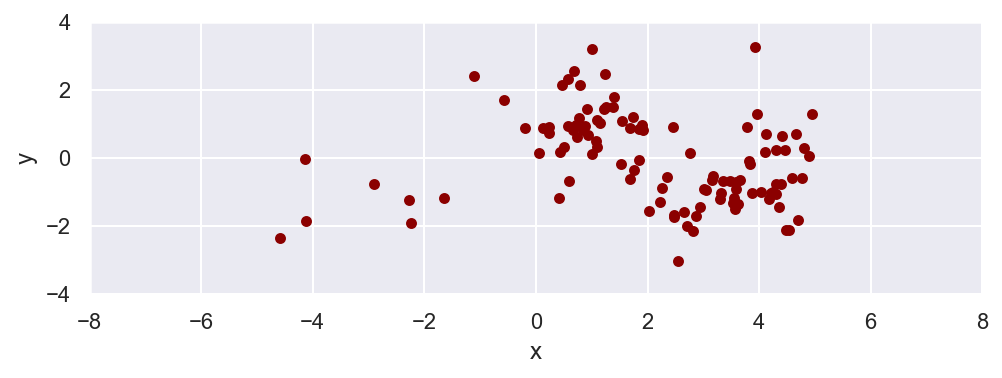

In [3]:
#vis data
df.plot.scatter(x='x',y='y',c='darkred',figsize=(8,2.5))
plt.xlim([-8,8])
plt.ylim([-4,4]);

In [4]:
# problem defines
alpha=0.16
beta=1.0
kernel=RBF(0.5)
x_train=df['x'].values
y_train=df['y'].values

In [5]:
class GaussianProcessRegressor:
    def __init__(self, alpha,beta,length_scale=0.5):
        self.kernel=RBF(length_scale)
        self.alpha=alpha
        self.beta=beta
    
    def ret_C_mat(self, x_arr):
        '''
        x_arr ... np.ndarray. observed data(x) shape=(n_obs,)

        returns
        ----------
        (行列の行, 行列の列)
        '''
        return 1/self.alpha * np.matrix(self.kernel(x_arr.reshape(-1,1))) + 1/self.beta*np.eye(len(x_arr))

    def ret_c_arr(self,x_arr,x_new):
        '''
        x_arr ... np.ndarray. observed data(x) shape=(n_obs,)
        x_new ... np.ndarray

        returns
        ----------
        (ベクトル,linspace(x_newの行列))
        ベクトルのc、shapeは(len(x_arr),len(x_new))となっている。
        '''
        return 1/self.alpha * np.matrix(self.kernel(x_arr.reshape(-1,1), x_new.reshape(-1,1)))

    def ret_c_int(self,x_new):
        '''
        x_new ... np.ndarray

        returns
        ----------
        (len(x_new),)
        '''
        return 1/self.alpha * np.diag(self.kernel(x_new.reshape(-1,1))) + 1/self.beta

    def fit(self, X, y):
        self.X=X
        self.y=y
    
    def predict(self, X_new):
        '''
        平均と分散を返す
        '''
        C_mat=self.ret_C_mat(self.X)
        c_arr=self.ret_c_arr(self.X,X_new)
        c_int=self.ret_c_int(X_new)
        
        
        #結果が縦に並ぶベクトル
        mean=c_arr.T*C_mat**-1 * self.y.reshape(-1,1)
        mean=np.array(mean).reshape(-1)
        var=c_int- np.diag(c_arr.T*C_mat**-1 *c_arr)
        
        return mean,var

In [6]:
gp=GaussianProcessRegressor(alpha,beta)
gp.fit(x_train,y_train)

In [7]:
x_test=np.linspace(-7,7,num=1000)

In [8]:
y_pred,var_pred=gp.predict(x_test)

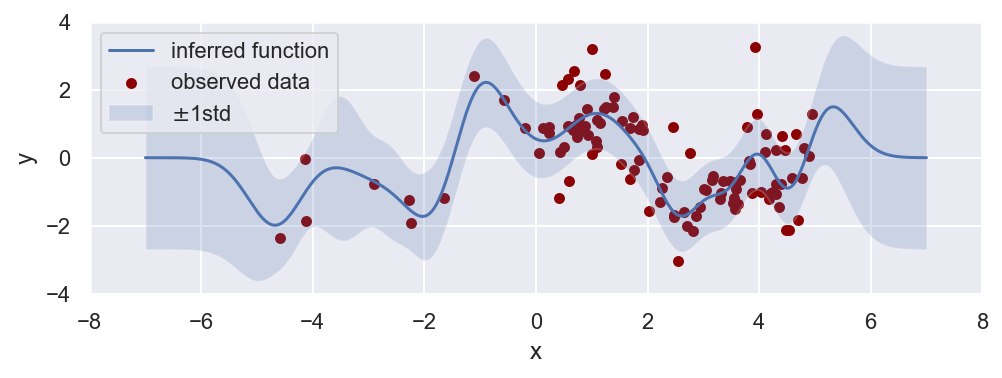

In [9]:
std_pred=np.sqrt(var_pred)
under,upper=y_pred-std_pred,y_pred+std_pred
df.plot.scatter(x='x',y='y',c='darkred',figsize=(8,2.5),label='observed data')
plt.plot(x_test,y_pred,label='inferred function')
plt.fill_between(x_test,under,upper,alpha=0.2, label='$\pm$1std')
plt.xlim([-8,8])
plt.ylim([-4,4])
plt.legend();